In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [56]:
from sklearn.preprocessing import *
from sklearn.model_selection import *

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

In [58]:
df = pd.read_parquet('./parquet/preprocessed.parquet')

Drop unnecessary columns


In [59]:
df = df.drop(['ID', 'Dt_Customer', 'Kidhome', 'Teenhome'],
             axis=1).reset_index(drop=True)

In [60]:
columns = df.columns
columns_to_drop = [col for col in columns if col.startswith('Marital_')]
df = df.drop(columns=columns_to_drop)

## Modelling


In [61]:
from sklearn.svm import *
from sklearn.naive_bayes import *
from sklearn.tree import *
from sklearn.neighbors import *
from sklearn.linear_model import *

In [62]:
X = df.drop('Response', axis=1)
y = df.Response

pd.set_option('display.max_columns', 50)
X

,Year_Birth,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Total_Children,Days_Since_Customer,Education_Basic,Education_Graduation,Education_Master,Education_PhD,A_Marital_Status_Married_Kidhome,A_Marital_Status_Married_Teenhome,A_Marital_Status_Single_Kidhome,A_Marital_Status_Single_Teenhome,A_Marital_Status_Together_Kidhome,A_Marital_Status_Together_Teenhome,A_Marital_Status_Widow_Kidhome,A_Marital_Status_Widow_Teenhome
0,1961,57091.0,0,464,5,64,7,0,37,1,7,3,7,5,0,0,3544,False,True,False,False,0,0,0,0,0,0,0,0
1,1958,67267.0,0,134,11,59,15,2,30,1,3,2,5,2,0,1,3577,False,True,False,False,0,1,0,0,0,0,0,0
2,1967,32474.0,0,10,0,1,0,0,0,1,1,0,2,7,0,2,3401,False,True,False,False,0,0,0,0,1,1,0,0
3,1989,21474.0,0,6,16,24,11,0,34,2,3,1,2,7,0,1,3494,False,True,False,False,0,0,1,0,0,0,0,0
4,1967,44931.0,0,78,0,11,0,0,7,1,2,1,3,5,0,1,3692,False,True,False,False,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1209,1974,20130.0,99,0,6,3,7,6,12,1,1,0,3,8,0,0,3634,False,False,False,False,0,0,0,0,0,0,0,0
1210,1973,42429.0,99,55,0,6,2,0,4,2,1,1,3,5,0,1,3404,False,True,False,False,0,0,0,0,0,0,0,1
1211,1973,42429.0,99,55,0,6,2,0,4,2,1,1,3,5,0,1,3404,False,True,False,False,0,0,0,0,0,0,0,1
1212,1977,31056.0,99,5,10,13,3,8,16,1,1,0,3,8,0,1,4053,False,False,False,False,1,0,0,0,0,0,0,0


In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=12)

In [64]:
pf = PolynomialFeatures(interaction_only=True)
X_train = pf.fit_transform(X_train)
X_test = pf.transform(X_test)

In [65]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [66]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

In [67]:
def assess_cv(model, name):
    accuracy = cross_val_score(
        model, X_train, y_train, cv=skf, scoring='accuracy')
    precision = cross_val_score(
        model, X_train, y_train, cv=skf, scoring='precision')
    recall = cross_val_score(model, X_train, y_train, cv=skf, scoring='recall')
    f1 = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1')
    roc = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc')

    eval = {name: {} for n in range(5)}
    eval[name]['Accuracy'] = accuracy.mean()
    eval[name]['Precision'] = precision.mean()
    eval[name]['Recall'] = recall.mean()
    eval[name]['F1 Score'] = f1.mean()
    eval[name]['ROC AUC'] = roc.mean()
    return pd.DataFrame(eval).T

In [68]:
def eval(predictions):
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, preds)
    print("Accuracy: %.4f" % acc)
    print("Precision: %.4f" % prec)
    print("Recall: %.4f" % rec)
    print("F1: %.4f" % f1)
    print("AUC: %.4f" % auc)

In [69]:
overview = pd.DataFrame({
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC AUC': []
})

### Logistic Regression


In [70]:
params = {
    'max_iter': [50, 70, 100, 200, 500, 1000, 2000, 5000]
}

In [71]:
clf_lr = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=params,
    scoring='f1',
    cv=skf
)

In [72]:
clf_lr.fit(X_train, y_train)

d:\Programming Files\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Programming Files\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

d:\Programming Files\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=12, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'max_iter': [50, 70, 100, 200, 500, 1000, 2000, 5000]},
             scoring='f1')

In [73]:
clf_lr.best_estimator_

LogisticRegression(max_iter=50)

In [74]:
pd.DataFrame(clf_lr.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.042025,0.000962,0.002398,0.000489,50,{'max_iter': 50},0.368421,0.451613,0.500000,0.307692,0.432432,0.412032,0.067097,1
1,0.056862,0.000960,0.002503,0.000446,70,{'max_iter': 70},0.378378,0.400000,0.411765,0.296296,0.400000,0.377288,0.041907,8
2,0.061882,0.004447,0.002199,0.000401,100,{'max_iter': 100},0.388889,0.400000,0.411765,0.296296,0.400000,0.379390,0.042172,2
3,0.063283,0.005555,0.002200,0.000401,200,{'max_iter': 200},0.388889,0.400000,0.411765,0.296296,0.400000,0.379390,0.042172,2
4,0.056424,0.004148,0.002002,0.000007,500,{'max_iter': 500},0.388889,0.400000,0.411765,0.296296,0.400000,0.379390,0.042172,2
5,0.058107,0.003181,0.002005,0.000010,1000,{'max_iter': 1000},0.388889,0.400000,0.411765,0.296296,0.400000,0.379390,0.042172,2
6,0.057332,0.003234,0.002011,0.000012,2000,{'max_iter': 2000},0.388889,0.400000,0.411765,0.296296,0.400000,0.379390,0.042172,2
7,0.057342,0.003592,0.002007,0.000011,5000,{'max_iter': 5000},0.388889,0.400000,0.411765,0.296296,0.400000,0.379390,0.042172,2


In [75]:
print(pd.DataFrame(clf_lr.cv_results_)[
      ['param_max_iter', 'mean_test_score', 'rank_test_score']].to_latex(index=False))

\begin{tabular}{lrr}
\toprule
param_max_iter & mean_test_score & rank_test_score \\
\midrule
50 & 0.412032 & 1 \\
70 & 0.377288 & 8 \\
100 & 0.379390 & 2 \\
200 & 0.379390 & 2 \\
500 & 0.379390 & 2 \\
1000 & 0.379390 & 2 \\
2000 & 0.379390 & 2 \\
5000 & 0.379390 & 2 \\
\bottomrule
\end{tabular}



In [76]:
# scores = cross_val_score(clf_lr.best_estimator_, X_train, y_train, cv=skf, scoring='roc_auc')
assess_cv(clf_lr.best_estimator_, 'Logistic Regression')

d:\Programming Files\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Programming Files\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

,Accuracy,F1 Score,Precision,ROC AUC,Recall
Logistic Regression,0.899096,0.412032,0.461903,0.801161,0.388889


In [77]:
overview = pd.concat([overview, assess_cv(
    clf_lr.best_estimator_, 'Logistic Regression')])

d:\Programming Files\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Programming Files\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

### SVM


In [78]:
params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
}

In [79]:
clf_svc = GridSearchCV(
    estimator=SVC(),
    param_grid=params,
    scoring='f1',
    cv=skf
)

In [80]:
clf_svc.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=12, shuffle=True),
             estimator=SVC(),
             param_grid={'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='f1')

In [81]:
clf_svc.best_estimator_

SVC(kernel='linear')

In [82]:
pd.DataFrame(clf_svc.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.033373,0.001939,0.004402,0.000795,scale,linear,"{'gamma': 'scale', 'kernel': 'linear'}",0.410256,0.432432,0.444444,0.294118,0.444444,0.405139,0.056898,1
1,0.020123,0.000466,0.005398,0.000486,scale,poly,"{'gamma': 'scale', 'kernel': 'poly'}",0.086957,0.000000,0.076923,0.000000,0.090909,0.050958,0.041856,4
2,0.021827,0.000654,0.011403,0.000495,scale,rbf,"{'gamma': 'scale', 'kernel': 'rbf'}",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5
3,0.017075,0.001705,0.004620,0.000508,scale,sigmoid,"{'gamma': 'scale', 'kernel': 'sigmoid'}",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5
4,0.031394,0.001604,0.003807,0.000397,auto,linear,"{'gamma': 'auto', 'kernel': 'linear'}",0.410256,0.432432,0.444444,0.294118,0.444444,0.405139,0.056898,1
5,0.018523,0.000434,0.005394,0.000486,auto,poly,"{'gamma': 'auto', 'kernel': 'poly'}",0.086957,0.000000,0.083333,0.000000,0.090909,0.052240,0.042721,3
6,0.020203,0.000985,0.011699,0.000871,auto,rbf,"{'gamma': 'auto', 'kernel': 'rbf'}",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5
7,0.015811,0.000755,0.004473,0.000449,auto,sigmoid,"{'gamma': 'auto', 'kernel': 'sigmoid'}",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5


In [83]:
print(pd.DataFrame(clf_svc.cv_results_)[
      ['param_gamma', 'param_kernel', 'mean_test_score', 'rank_test_score']].to_latex(index=False))

\begin{tabular}{llrr}
\toprule
param_gamma & param_kernel & mean_test_score & rank_test_score \\
\midrule
scale & linear & 0.405139 & 1 \\
scale & poly & 0.050958 & 4 \\
scale & rbf & 0.000000 & 5 \\
scale & sigmoid & 0.000000 & 5 \\
auto & linear & 0.405139 & 1 \\
auto & poly & 0.052240 & 3 \\
auto & rbf & 0.000000 & 5 \\
auto & sigmoid & 0.000000 & 5 \\
\bottomrule
\end{tabular}



In [84]:
# scores = cross_val_score(clf_svc.best_estimator_, X_train, y_train, cv=skf, scoring='precision')
assess_cv(clf_svc.best_estimator_, 'SVM')

,Accuracy,F1 Score,Precision,ROC AUC,Recall
SVM,0.888781,0.405139,0.400679,0.770827,0.411111


In [85]:
overview = pd.concat([overview, assess_cv(clf_svc.best_estimator_, 'SVM')])

### Naive Bayes


In [86]:
params = {
    'alpha': [1.0, 2.0, 5.0, 7, 10],
    'fit_prior': [True, False],
}

In [87]:
clf_nb = GridSearchCV(
    estimator=BernoulliNB(),
    param_grid=params,
    scoring='f1',
    cv=skf
)

In [88]:
clf_nb.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=12, shuffle=True),
             estimator=BernoulliNB(),
             param_grid={'alpha': [1.0, 2.0, 5.0, 7, 10],
                         'fit_prior': [True, False]},
             scoring='f1')

In [89]:
clf_nb.best_estimator_

BernoulliNB(alpha=2.0)

In [90]:
pd.DataFrame(clf_nb.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_prior,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006634,0.000456,0.002806,0.000405,1.0,True,"{'alpha': 1.0, 'fit_prior': True}",0.250000,0.339623,0.309859,0.350877,0.278481,0.305768,0.037556,3
1,0.007807,0.001474,0.003393,0.000486,1.0,False,"{'alpha': 1.0, 'fit_prior': False}",0.263158,0.354839,0.285714,0.323529,0.318182,0.309084,0.031750,2
2,0.007233,0.001129,0.003606,0.000801,2.0,True,"{'alpha': 2.0, 'fit_prior': True}",0.257143,0.333333,0.333333,0.344828,0.285714,0.310870,0.033710,1
3,0.006608,0.001016,0.003195,0.000398,2.0,False,"{'alpha': 2.0, 'fit_prior': False}",0.240000,0.338983,0.297297,0.322581,0.285714,0.296915,0.034039,4
4,0.006386,0.000833,0.003058,0.000115,5.0,True,"{'alpha': 5.0, 'fit_prior': True}",0.241379,0.250000,0.305085,0.226415,0.297297,0.264035,0.031359,6
5,0.006395,0.000496,0.002611,0.000505,5.0,False,"{'alpha': 5.0, 'fit_prior': False}",0.208955,0.296296,0.307692,0.237288,0.311688,0.272384,0.041517,5
6,0.006108,0.000798,0.003401,0.000485,7,True,"{'alpha': 7, 'fit_prior': True}",0.222222,0.232558,0.301887,0.244898,0.307692,0.261851,0.035834,7
7,0.006399,0.000494,0.003011,0.000007,7,False,"{'alpha': 7, 'fit_prior': False}",0.203390,0.244898,0.295082,0.222222,0.281690,0.249456,0.034656,8
8,0.006406,0.000500,0.003507,0.000458,10,True,"{'alpha': 10, 'fit_prior': True}",0.222222,0.205128,0.250000,0.255319,0.310345,0.248603,0.035903,10
9,0.006210,0.000400,0.002990,0.000013,10,False,"{'alpha': 10, 'fit_prior': False}",0.188679,0.238095,0.269231,0.250000,0.300000,0.249201,0.036793,9


In [91]:
print(pd.DataFrame(clf_nb.cv_results_)[
      ['param_alpha', 'param_fit_prior', 'mean_test_score', 'rank_test_score']].to_latex(index=False))

\begin{tabular}{llrr}
\toprule
param_alpha & param_fit_prior & mean_test_score & rank_test_score \\
\midrule
1.000000 & True & 0.305768 & 3 \\
1.000000 & False & 0.309084 & 2 \\
2.000000 & True & 0.310870 & 1 \\
2.000000 & False & 0.296915 & 4 \\
5.000000 & True & 0.264035 & 6 \\
5.000000 & False & 0.272384 & 5 \\
7 & True & 0.261851 & 7 \\
7 & False & 0.249456 & 8 \\
10 & True & 0.248603 & 10 \\
10 & False & 0.249201 & 9 \\
\bottomrule
\end{tabular}



In [92]:
# scores = cross_val_score(clf_nb, X_train, y_train, cv=skf, scoring='f1')
assess_cv(clf_nb.best_estimator_, 'Naive Bayes')

,Accuracy,F1 Score,Precision,ROC AUC,Recall
Naive Bayes,0.768316,0.31087,0.217737,0.760116,0.555556


In [93]:
tt = pd.concat([assess_cv(clf_nb.best_estimator_, 'Bernoulli NB'),
               assess_cv(GaussianNB(), 'Gaussian NB')])

In [94]:
print(tt.to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & Accuracy & F1 Score & Precision & ROC AUC & Recall \\
\midrule
Bernoulli NB & 0.768316 & 0.310870 & 0.217737 & 0.760116 & 0.555556 \\
Gaussian NB & 0.244092 & 0.176973 & 0.098413 & 0.530368 & 0.877778 \\
\bottomrule
\end{tabular}



In [95]:
tt

,Accuracy,F1 Score,Precision,ROC AUC,Recall
Bernoulli NB,0.768316,0.310870,0.217737,0.760116,0.555556
Gaussian NB,0.244092,0.176973,0.098413,0.530368,0.877778


In [96]:
overview = pd.concat([overview, assess_cv(clf_nb, 'Naive Bayes')])

### Decision Tree


In [97]:
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'min_samples_split': [2, 5, 10]
}

In [98]:
clf_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=params,
    scoring='f1',
    cv=skf
)

In [99]:

clf_dt.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=12, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             scoring='f1')

In [100]:
clf_dt.best_estimator_

DecisionTreeClassifier(criterion='entropy', min_samples_split=5,
                       splitter='random')

In [101]:
pd.DataFrame(clf_dt.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_min_samples_split,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.069951,0.008487,0.001993,0.000017,gini,2,best,"{'criterion': 'gini', 'min_samples_split': 2, ...",0.363636,0.378378,0.292683,0.486486,0.457143,0.395665,0.069221,9
1,0.014507,0.000887,0.001800,0.000397,gini,2,random,"{'criterion': 'gini', 'min_samples_split': 2, ...",0.279070,0.368421,0.380952,0.400000,0.256410,0.336971,0.057860,15
2,0.068631,0.010139,0.001803,0.000398,gini,5,best,"{'criterion': 'gini', 'min_samples_split': 5, ...",0.333333,0.424242,0.400000,0.484848,0.514286,0.431342,0.063845,2
3,0.012442,0.001049,0.002194,0.000392,gini,5,random,"{'criterion': 'gini', 'min_samples_split': 5, ...",0.258065,0.363636,0.400000,0.148148,0.411765,0.316323,0.100026,17
4,0.067333,0.009544,0.002014,0.000008,gini,10,best,"{'criterion': 'gini', 'min_samples_split': 10,...",0.380952,0.578947,0.272727,0.484848,0.424242,0.428344,0.102326,3
5,0.013099,0.001910,0.002006,0.000003,gini,10,random,"{'criterion': 'gini', 'min_samples_split': 10,...",0.200000,0.270270,0.325581,0.470588,0.400000,0.333288,0.094972,16
6,0.053118,0.002674,0.002015,0.000626,entropy,2,best,"{'criterion': 'entropy', 'min_samples_split': ...",0.388889,0.473684,0.315789,0.437500,0.400000,0.403173,0.052915,8
7,0.012210,0.000752,0.001997,0.000012,entropy,2,random,"{'criterion': 'entropy', 'min_samples_split': ...",0.318182,0.400000,0.400000,0.428571,0.387097,0.386770,0.036883,12
8,0.052870,0.002294,0.001600,0.000488,entropy,5,best,"{'criterion': 'entropy', 'min_samples_split': ...",0.410256,0.540541,0.315789,0.357143,0.400000,0.404746,0.075726,7
9,0.011515,0.000772,0.001797,0.000416,entropy,5,random,"{'criterion': 'entropy', 'min_samples_split': ...",0.424242,0.400000,0.411765,0.378378,0.571429,0.437163,0.068813,1


In [102]:
print(pd.DataFrame(clf_dt.cv_results_)[['param_criterion', 'param_min_samples_split',
      'param_splitter', 'mean_test_score', 'rank_test_score']].to_latex(index=False))

\begin{tabular}{lllrr}
\toprule
param_criterion & param_min_samples_split & param_splitter & mean_test_score & rank_test_score \\
\midrule
gini & 2 & best & 0.395665 & 9 \\
gini & 2 & random & 0.336971 & 15 \\
gini & 5 & best & 0.431342 & 2 \\
gini & 5 & random & 0.316323 & 17 \\
gini & 10 & best & 0.428344 & 3 \\
gini & 10 & random & 0.333288 & 16 \\
entropy & 2 & best & 0.403173 & 8 \\
entropy & 2 & random & 0.386770 & 12 \\
entropy & 5 & best & 0.404746 & 7 \\
entropy & 5 & random & 0.437163 & 1 \\
entropy & 10 & best & 0.367016 & 13 \\
entropy & 10 & random & 0.423929 & 4 \\
log_loss & 2 & best & 0.415253 & 5 \\
log_loss & 2 & random & 0.288045 & 18 \\
log_loss & 5 & best & 0.408936 & 6 \\
log_loss & 5 & random & 0.393803 & 10 \\
log_loss & 10 & best & 0.390678 & 11 \\
log_loss & 10 & random & 0.359456 & 14 \\
\bottomrule
\end{tabular}



In [103]:
assess_cv(clf_dt.best_estimator_, 'Decision Tree')

,Accuracy,F1 Score,Precision,ROC AUC,Recall
Decision Tree,0.897024,0.427237,0.431644,0.661299,0.277778


In [104]:
overview = pd.concat([overview, assess_cv(
    clf_dt.best_estimator_, 'Decision Tree')])

### K-Nearest Neighbors


In [105]:
params = {
    'n_neighbors': [1, 2, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [106]:
clf_kn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=params,
    scoring='f1',
    cv=skf
)

In [107]:
clf_kn.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=12, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 5, 7, 10],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [108]:
clf_kn.best_estimator_

KNeighborsClassifier(n_neighbors=1)

In [109]:
pd.DataFrame(clf_kn.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002202,0.000400,0.012106,0.000488,auto,1,uniform,"{'algorithm': 'auto', 'n_neighbors': 1, 'weigh...",0.235294,0.410256,0.270270,0.307692,0.375000,0.319703,0.064762,1
11,0.011816,0.000401,0.052858,0.000390,ball_tree,1,distance,"{'algorithm': 'ball_tree', 'n_neighbors': 1, '...",0.235294,0.410256,0.270270,0.307692,0.375000,0.319703,0.064762,1
30,0.002010,0.000006,0.010694,0.000398,brute,1,uniform,"{'algorithm': 'brute', 'n_neighbors': 1, 'weig...",0.235294,0.410256,0.270270,0.307692,0.375000,0.319703,0.064762,1
31,0.002203,0.000397,0.011301,0.001072,brute,1,distance,"{'algorithm': 'brute', 'n_neighbors': 1, 'weig...",0.235294,0.410256,0.270270,0.307692,0.375000,0.319703,0.064762,1
10,0.011501,0.000629,0.060091,0.000971,ball_tree,1,uniform,"{'algorithm': 'ball_tree', 'n_neighbors': 1, '...",0.235294,0.410256,0.270270,0.307692,0.375000,0.319703,0.064762,1
1,0.002404,0.001020,0.010898,0.001683,auto,1,distance,"{'algorithm': 'auto', 'n_neighbors': 1, 'weigh...",0.235294,0.410256,0.270270,0.307692,0.375000,0.319703,0.064762,1
21,0.020300,0.000607,0.061330,0.001558,kd_tree,1,distance,"{'algorithm': 'kd_tree', 'n_neighbors': 1, 'we...",0.235294,0.410256,0.270270,0.307692,0.363636,0.317430,0.062955,7
20,0.019789,0.000494,0.067836,0.001676,kd_tree,1,uniform,"{'algorithm': 'kd_tree', 'n_neighbors': 1, 'we...",0.235294,0.410256,0.270270,0.307692,0.363636,0.317430,0.062955,7
33,0.001903,0.000494,0.010401,0.001023,brute,2,distance,"{'algorithm': 'brute', 'n_neighbors': 2, 'weig...",0.235294,0.368421,0.277778,0.307692,0.375000,0.312837,0.053334,9
3,0.001903,0.000493,0.011001,0.000635,auto,2,distance,"{'algorithm': 'auto', 'n_neighbors': 2, 'weigh...",0.235294,0.368421,0.277778,0.307692,0.375000,0.312837,0.053334,9


In [110]:
print(pd.DataFrame(clf_kn.cv_results_).sort_values(by='rank_test_score')[
      ['param_algorithm', 'param_n_neighbors', 'param_weights', 'mean_test_score', 'rank_test_score']].to_latex(index=False))

\begin{tabular}{lllrr}
\toprule
param_algorithm & param_n_neighbors & param_weights & mean_test_score & rank_test_score \\
\midrule
auto & 1 & uniform & 0.319703 & 1 \\
ball_tree & 1 & distance & 0.319703 & 1 \\
brute & 1 & uniform & 0.319703 & 1 \\
brute & 1 & distance & 0.319703 & 1 \\
ball_tree & 1 & uniform & 0.319703 & 1 \\
auto & 1 & distance & 0.319703 & 1 \\
kd_tree & 1 & distance & 0.317430 & 7 \\
kd_tree & 1 & uniform & 0.317430 & 7 \\
brute & 2 & distance & 0.312837 & 9 \\
auto & 2 & distance & 0.312837 & 9 \\
ball_tree & 2 & distance & 0.312837 & 9 \\
kd_tree & 2 & distance & 0.312837 & 9 \\
auto & 7 & distance & 0.231143 & 13 \\
brute & 7 & distance & 0.231143 & 13 \\
kd_tree & 7 & distance & 0.231143 & 13 \\
ball_tree & 7 & distance & 0.231143 & 13 \\
auto & 5 & distance & 0.223317 & 17 \\
ball_tree & 5 & distance & 0.223317 & 17 \\
kd_tree & 5 & distance & 0.223317 & 17 \\
brute & 5 & distance & 0.223317 & 17 \\
kd_tree & 10 & distance & 0.200369 & 21 \\
ball_tree & 10 &

In [111]:
assess_cv(clf_kn.best_estimator_, 'K-Nearest Neighbors')

,Accuracy,F1 Score,Precision,ROC AUC,Recall
K-Nearest Neighbors,0.882612,0.319703,0.364536,0.621061,0.3


In [112]:
overview = pd.concat([overview, assess_cv(
    clf_kn.best_estimator_, 'K-Nearest Neighbors')])

In [113]:
overview

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,0.899096,0.461903,0.388889,0.412032,0.801161
SVM,0.888781,0.400679,0.411111,0.405139,0.770827
Naive Bayes,0.761121,0.205177,0.533333,0.294140,0.759150
Decision Tree,0.882606,0.382056,0.422222,0.388639,0.694270
K-Nearest Neighbors,0.882612,0.364536,0.300000,0.319703,0.621061


In [114]:
overview.T

,Logistic Regression,SVM,Naive Bayes,Decision Tree,K-Nearest Neighbors
Accuracy,0.899096,0.888781,0.761121,0.882606,0.882612
Precision,0.461903,0.400679,0.205177,0.382056,0.364536
Recall,0.388889,0.411111,0.533333,0.422222,0.300000
F1 Score,0.412032,0.405139,0.294140,0.388639,0.319703
ROC AUC,0.801161,0.770827,0.759150,0.694270,0.621061


In [115]:
print(overview.to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & Accuracy & Precision & Recall & F1 Score & ROC AUC \\
\midrule
Logistic Regression & 0.899096 & 0.461903 & 0.388889 & 0.412032 & 0.801161 \\
SVM & 0.888781 & 0.400679 & 0.411111 & 0.405139 & 0.770827 \\
Naive Bayes & 0.761121 & 0.205177 & 0.533333 & 0.294140 & 0.759150 \\
Decision Tree & 0.882606 & 0.382056 & 0.422222 & 0.388639 & 0.694270 \\
K-Nearest Neighbors & 0.882612 & 0.364536 & 0.300000 & 0.319703 & 0.621061 \\
\bottomrule
\end{tabular}



## Evaluation


### Logistic Regression


In [116]:
pd.DataFrame(pf.get_feature_names_out()).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435
0,1,Year_Birth,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Total_Children,Days_Since_Customer,Education_Basic,Education_Graduation,Education_Master,Education_PhD,A_Marital_Status_Married_Kidhome,A_Marital_Status_Married_Teenhome,A_Marital_Status_Single_Kidhome,...,A_Marital_Status_Married_Kidhome A_Marital_Sta...,A_Marital_Status_Married_Kidhome A_Marital_Sta...,A_Marital_Status_Married_Kidhome A_Marital_Sta...,A_Marital_Status_Married_Kidhome A_Marital_Sta...,A_Marital_Status_Married_Teenhome A_Marital_St...,A_Marital_Status_Married_Teenhome A_Marital_St...,A_Marital_Status_Married_Teenhome A_Marital_St...,A_Marital_Status_Married_Teenhome A_Marital_St...,A_Marital_Status_Married_Teenhome A_Marital_St...,A_Marital_Status_Married_Teenhome A_Marital_St...,A_Marital_Status_Single_Kidhome A_Marital_Stat...,A_Marital_Status_Single_Kidhome A_Marital_Stat...,A_Marital_Status_Single_Kidhome A_Marital_Stat...,A_Marital_Status_Single_Kidhome A_Marital_Stat...,A_Marital_Status_Single_Kidhome A_Marital_Stat...,A_Marital_Status_Single_Teenhome A_Marital_Sta...,A_Marital_Status_Single_Teenhome A_Marital_Sta...,A_Marital_Status_Single_Teenhome A_Marital_Sta...,A_Marital_Status_Single_Teenhome A_Marital_Sta...,A_Marital_Status_Together_Kidhome A_Marital_St...,A_Marital_Status_Together_Kidhome A_Marital_St...,A_Marital_Status_Together_Kidhome A_Marital_St...,A_Marital_Status_Together_Teenhome A_Marital_S...,A_Marital_Status_Together_Teenhome A_Marital_S...,A_Marital_Status_Widow_Kidhome A_Marital_Statu...


In [117]:
lr = clf_lr.best_estimator_

In [118]:
coefficients = pd.DataFrame(data=lr.coef_, columns=pf.get_feature_names_out())

In [119]:
top5 = coefficients.loc[0].sort_values(ascending=False).iloc[:5]

In [120]:
pd.DataFrame(data=top5.values, index=top5.index)

,0
MntFruits A_Marital_Status_Single_Kidhome,0.964310
MntMeatProducts A_Marital_Status_Married_Teenhome,0.909317
MntWines A_Marital_Status_Together_Teenhome,0.904126
MntWines NumWebPurchases,0.851960
Education_Master A_Marital_Status_Single_Kidhome,0.772630


### SVM


In [121]:
svm = clf_svc.best_estimator_

In [122]:
coefficients = pd.DataFrame(data=svm.coef_, columns=pf.get_feature_names_out())

In [123]:
top5 = coefficients.loc[0].sort_values(ascending=False).iloc[:5]

In [124]:
pd.DataFrame(top5)

,0
MntWines NumWebPurchases,0.904773
A_Marital_Status_Married_Kidhome A_Marital_Status_Married_Teenhome,0.804857
MntFruits A_Marital_Status_Single_Kidhome,0.803837
NumWebVisitsMonth A_Marital_Status_Single_Kidhome,0.769760
Recency Days_Since_Customer,0.733147


In [125]:
print(pd.DataFrame(top5).to_latex())

\begin{tabular}{lr}
\toprule
 & 0 \\
\midrule
MntWines NumWebPurchases & 0.904773 \\
A_Marital_Status_Married_Kidhome A_Marital_Status_Married_Teenhome & 0.804857 \\
MntFruits A_Marital_Status_Single_Kidhome & 0.803837 \\
NumWebVisitsMonth A_Marital_Status_Single_Kidhome & 0.769760 \\
Recency Days_Since_Customer & 0.733147 \\
\bottomrule
\end{tabular}



In [126]:
svecs = pd.DataFrame(sc.inverse_transform(
    svm.support_vectors_), columns=pf.get_feature_names_out())

In [127]:
print(svecs.mean())

1                                                                         1.000000
Year_Birth                                                             1970.030303
Income                                                                37390.267677
Recency                                                                  30.606061
MntWines                                                                101.590909
                                                                          ...     
A_Marital_Status_Together_Kidhome A_Marital_Status_Widow_Kidhome          0.000000
A_Marital_Status_Together_Kidhome A_Marital_Status_Widow_Teenhome         0.000000
A_Marital_Status_Together_Teenhome A_Marital_Status_Widow_Kidhome         0.000000
A_Marital_Status_Together_Teenhome A_Marital_Status_Widow_Teenhome        0.000000
A_Marital_Status_Widow_Kidhome A_Marital_Status_Widow_Teenhome            0.015152
Length: 436, dtype: float64


In [128]:
X_train.shape

(971, 436)

In [129]:
svecs.shape

(198, 436)

In [130]:
svm.n_support_

array([131,  67])

In [131]:
198/971

0.203913491246138

### Naive Bayes


In [132]:
nb = clf_nb.best_estimator_

In [133]:
df.value_counts('Response')

Response
0    1101
1     113
Name: count, dtype: int64

In [134]:
nb.class_log_prior_

array([-0.09726884, -2.3785168 ])

In [135]:
flp = pd.DataFrame(nb.feature_log_prob_, columns=pf.get_feature_names_out())

In [136]:
print(pd.DataFrame(flp.loc[0].sort_values(
    ascending=False).iloc[:5]).to_latex())

\begin{tabular}{lr}
\toprule
 & 0 \\
\midrule
Year_Birth & -0.624380 \\
Year_Birth Recency & -0.641402 \\
NumCatalogPurchases Days_Since_Customer & -0.650023 \\
NumCatalogPurchases & -0.650023 \\
Recency & -0.650023 \\
\bottomrule
\end{tabular}



## Decision Trees


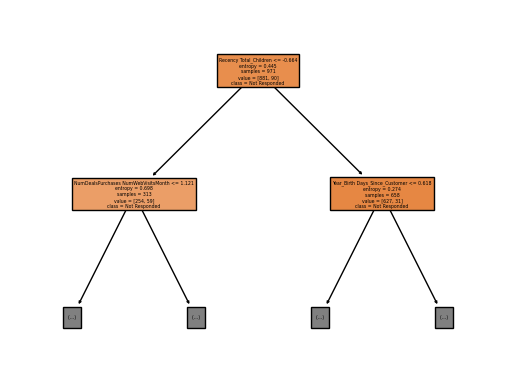

In [143]:
from sklearn.tree import plot_tree

plot_tree(clf_dt.best_estimator_, filled=True, feature_names=pf.get_feature_names_out(
), class_names=['Not Responded', 'Responded'], max_depth=1)
plt.show()

## K-Nearest Neighbors
